# IMPORTS AND READ CSV

In [613]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import yule_walker
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [446]:
df_time_series = pd.read_csv('datasets/historical_demand_sum.csv', index_col='time_index')
df_time_series.index = pd.to_datetime(df_time_series.index)
df_time_series.index = df_time_series.asfreq('MS').index
df_time_series.head()

,demand_MWh
time_index,
2012-01-01,1.080470e+07
2012-02-01,1.008555e+07
2012-03-01,1.017537e+07
2012-04-01,8.969068e+06
2012-05-01,9.597272e+06


<AxesSubplot: xlabel='time_index'>

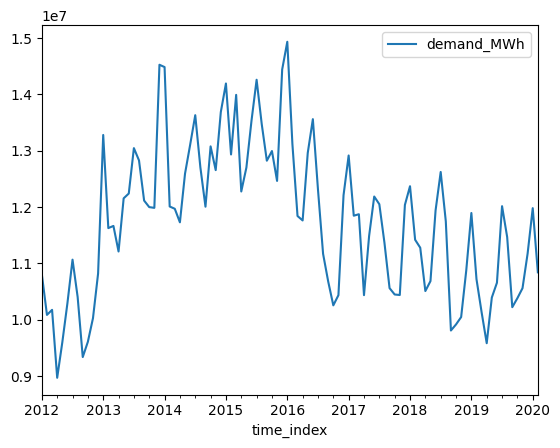

In [447]:
df_time_series.plot()

# CREATE A TIME DUMMY

In [448]:
df_time_series.index.size

98

In [449]:
df_time_series['time_dummy'] = np.arange(df_time_series.index.size)

In [450]:
df_time_series.head()

,demand_MWh,time_dummy
time_index,,
2012-01-01,1.080470e+07,0
2012-02-01,1.008555e+07,1
2012-03-01,1.017537e+07,2
2012-04-01,8.969068e+06,3
2012-05-01,9.597272e+06,4


In [451]:
X = df_time_series[['time_dummy']]
y = df_time_series['demand_MWh']

In [452]:
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

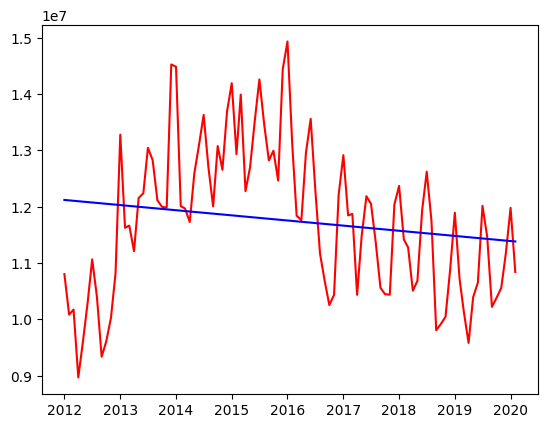

In [453]:

# ax.set_ylabel("Monthly Difference")
plt.plot(df_time_series[['demand_MWh']], c='red')
plt.plot(y_pred, c='blue')
plt.show()

# LAG FEATURE

In [454]:
df_time_series2 = df_time_series.copy()
df_time_series2['demand_MWh_shifted'] = df_time_series2['demand_MWh'].shift(1)
df_time_series2.dropna(inplace=True)

In [455]:
df_time_series2

,demand_MWh,time_dummy,demand_MWh_shifted
time_index,,,
2012-02-01,1.008555e+07,1,1.080470e+07
2012-03-01,1.017537e+07,2,1.008555e+07
2012-04-01,8.969068e+06,3,1.017537e+07
2012-05-01,9.597272e+06,4,8.969068e+06
2012-06-01,1.029218e+07,5,9.597272e+06
...,...,...,...
2019-10-01,1.038260e+07,93,1.022258e+07
2019-11-01,1.055948e+07,94,1.038260e+07
2019-12-01,1.117532e+07,95,1.055948e+07


In [456]:
X = df_time_series2[['demand_MWh_shifted']]
y = df_time_series2['demand_MWh']

In [457]:
X.head()

,demand_MWh_shifted
time_index,
2012-02-01,1.080470e+07
2012-03-01,1.008555e+07
2012-04-01,1.017537e+07
2012-05-01,8.969068e+06
2012-06-01,9.597272e+06


In [459]:
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

[None,
 Text(0, 0.5, 'sales'),
 Text(0.5, 0, 'demand_MWh_shifted'),
 Text(0.5, 1.0, 'Lag Plot')]

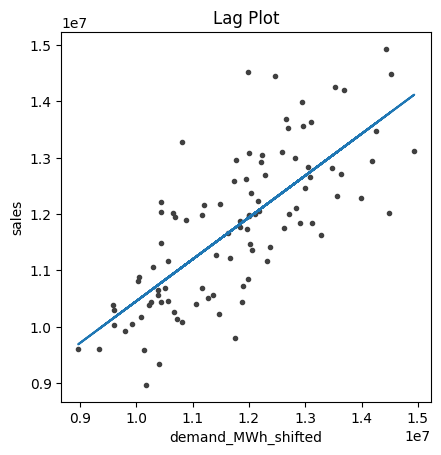

In [460]:
fig, ax = plt.subplots()
ax.plot(X['demand_MWh_shifted'], y, '.', color='0.25')
ax.plot(X['demand_MWh_shifted'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='demand_MWh_shifted', title='Lag Plot')

# TREND

In [461]:
df_time_series3 = df_time_series2.copy()
trend = df_time_series3['demand_MWh'].rolling(
    window=12,
    min_periods=6,
    center=True
).mean()

In [462]:
dp = DeterministicProcess(
    index=df_time_series3.index,     # dates from the training data
    constant=True,                  # dummy feature for the bias (y_intercept)
    order=1,                        # the time dummy (trend)
    drop=True,                      # drop terms if necessary to avoid collinearity
)
X = dp.in_sample()
X.index

DatetimeIndex(['2012-02-01', '2012-03-01', '2012-04-01', '2012-05-01',
               '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01',
               '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01',
               '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01',
               '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01',
               '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
               '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
               '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
               '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
               '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
               '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
               '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
               '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
      

In [463]:
X.head()

,const,trend
time_index,,
2012-02-01,1.0,1.0
2012-03-01,1.0,2.0
2012-04-01,1.0,3.0
2012-05-01,1.0,4.0
2012-06-01,1.0,5.0


In [464]:
# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
# model.predict(X_train).reshape(-1)
y_pred = pd.Series(model.predict(X), index=X.index)

In [465]:
df_time_series['demand_MWh'].size

98

In [466]:
y.head()

time_index
2012-02-01    1.008555e+07
2012-03-01    1.017537e+07
2012-04-01    8.969068e+06
2012-05-01    9.597272e+06
2012-06-01    1.029218e+07
Freq: MS, Name: demand_MWh, dtype: float64

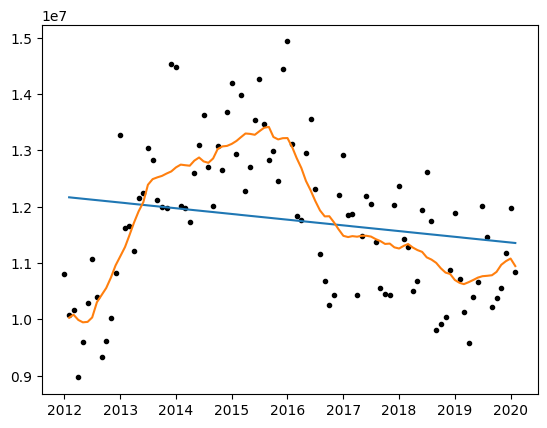

In [467]:
plt.scatter(df_time_series.index, df_time_series['demand_MWh'], c='black', marker='.')
plt.plot(y_pred)
plt.plot(trend)


In [468]:
X = dp.out_of_sample(30)
X.index

DatetimeIndex(['2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [469]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2020-03-01    1.134861e+07
2020-04-01    1.134016e+07
2020-05-01    1.133171e+07
2020-06-01    1.132326e+07
2020-07-01    1.131481e+07
Freq: MS, dtype: float64

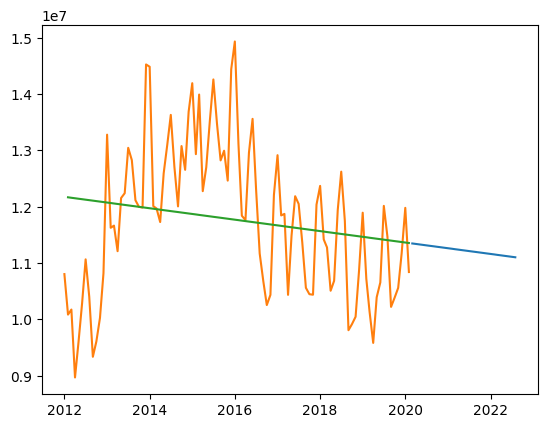

In [470]:
plt.plot(y_fore)
plt.plot(df_time_series['demand_MWh'])
plt.plot(y_pred)

# SEASONALITY

In [472]:
df_time_series.head()

,demand_MWh,time_dummy
time_index,,
2012-01-01,1.080470e+07,0
2012-02-01,1.008555e+07,1
2012-03-01,1.017537e+07,2
2012-04-01,8.969068e+06,3
2012-05-01,9.597272e+06,4


In [473]:
# df_time_series_seasonality = df_time_series.drop(columns=['time_dummy', 'demand_MWh_shifted'])
df_time_series_seasonality = df_time_series.drop(columns=['time_dummy'])
df_time_series_seasonality

,demand_MWh
time_index,
2012-01-01,1.080470e+07
2012-02-01,1.008555e+07
2012-03-01,1.017537e+07
2012-04-01,8.969068e+06
2012-05-01,9.597272e+06
...,...
2019-10-01,1.038260e+07
2019-11-01,1.055948e+07
2019-12-01,1.117532e+07


In [480]:
df_time_series_seasonality['month'] = df_time_series_seasonality.index.month
df_time_series_seasonality['year'] = df_time_series_seasonality.index.year
df_time_series_seasonality['four_months_period'] = utils.four_months_period(df_time_series_seasonality)
df_time_series_seasonality['six_months_period'] = utils.six_months_period(df_time_series_seasonality)

In [482]:
y = df_time_series_seasonality['demand_MWh']

The periodogram plot remains pending to be fixed. Data doesn't have weekly frequency

/home/tomas/codes/electric_energy_demand_argentina/utils.py:51: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

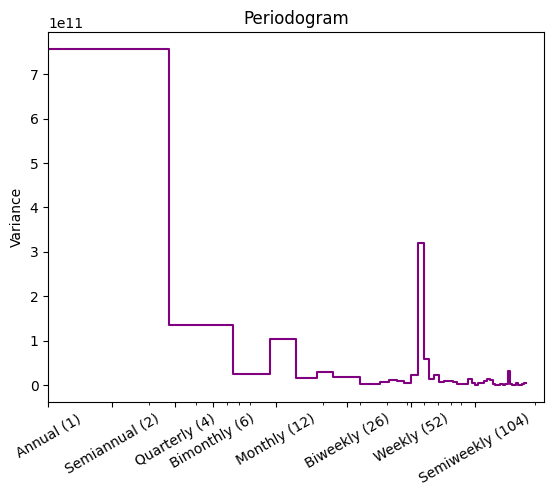

In [483]:
utils.plot_periodogram(df_time_series_seasonality['demand_MWh']) 

In [484]:
fourier = CalendarFourier(freq="A", order=2)
dp = DeterministicProcess(
    index=df_time_series.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()

<AxesSubplot: xlabel='time_index'>

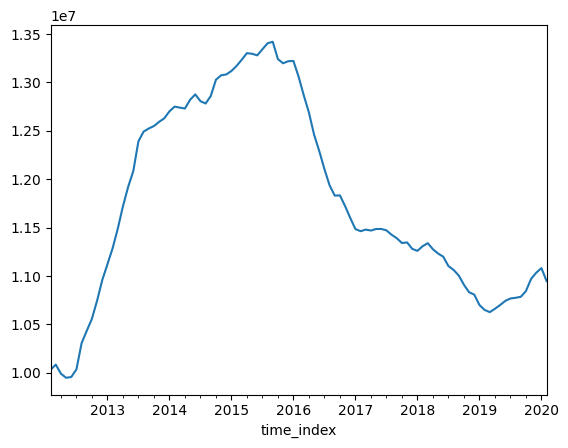

In [485]:
trend.plot()

In [486]:
X.head()

,const,trend,trend_squared,trend_cubed,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
time_index,,,,,,,,,,,,,,,,,,,
2012-01-01,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000
2012-02-01,1.0,2.0,4.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507415,0.861702,0.874481,0.485060
2012-03-01,1.0,3.0,9.0,27.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.857315,0.514793,0.882679,-0.469977
2012-04-01,1.0,4.0,16.0,64.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999963,0.008583,0.017166,-0.999853
2012-05-01,1.0,5.0,25.0,125.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.874481,-0.485060,-0.848351,-0.529434


In [487]:
y.head()

time_index
2012-01-01    1.080470e+07
2012-02-01    1.008555e+07
2012-03-01    1.017537e+07
2012-04-01    8.969068e+06
2012-05-01    9.597272e+06
Freq: MS, Name: demand_MWh, dtype: float64

R2 training: 0.8725521599475758


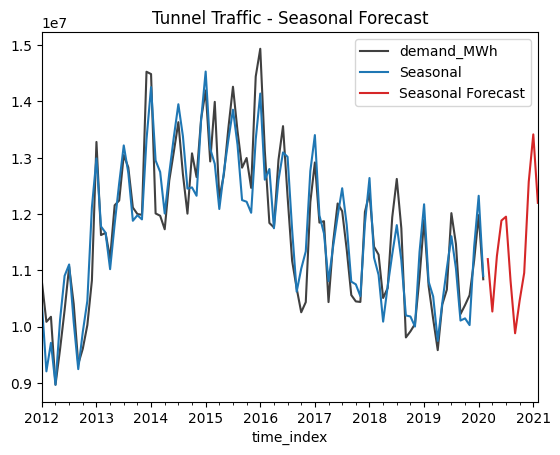

In [488]:

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=12)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()
print(f'R2 training: {r2_score(y, y_pred)}')

/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


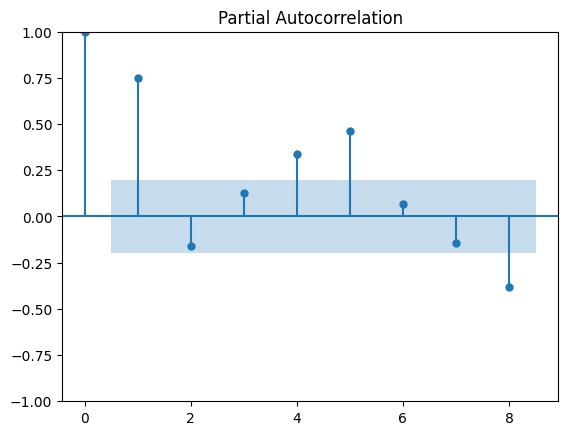

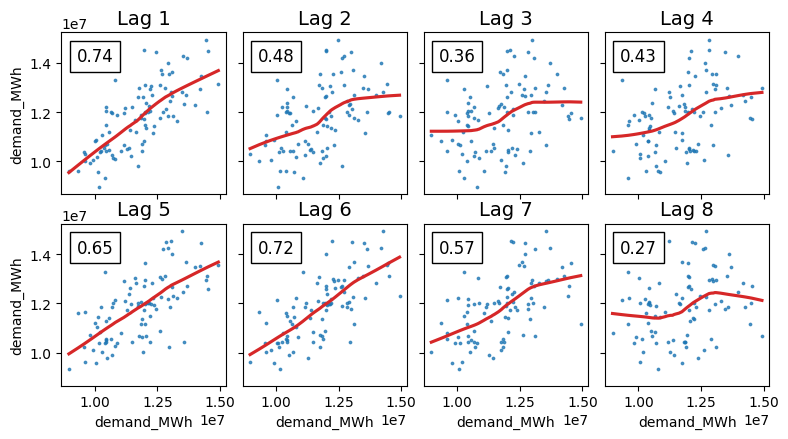

In [489]:
plot_pacf(df_time_series['demand_MWh'], lags=8);
utils.plot_lags(df_time_series['demand_MWh'], lags=8, nrows=2);


# ADDING BUSINESS DAYS AS FEATURE

In [491]:
df_time_series4 = df_time_series.copy()
df_time_series4['demand_MWh_shifted'] = df_time_series4['demand_MWh'].shift(1) 
df_time_series4['demand_MWh_shifted2'] = df_time_series4['demand_MWh_shifted'].shift(1) 
df_time_series4['demand_MWh_shifted3'] = df_time_series4['demand_MWh_shifted2'].shift(1) 
df_time_series4['demand_MWh_shifted4'] = df_time_series4['demand_MWh_shifted3'].shift(1) 
df_time_series4['demand_MWh_shifted5'] = df_time_series4['demand_MWh_shifted4'].shift(1) 
df_time_series4.dropna(inplace=True)

In [492]:
df_time_series4['business_days'] = [ np.busday_count(i.date(), (i + pd.DateOffset(months=1)).date()) for i in df_time_series4.index]
df_time_series4

,demand_MWh,time_dummy,demand_MWh_shifted,demand_MWh_shifted2,demand_MWh_shifted3,demand_MWh_shifted4,demand_MWh_shifted5,business_days
time_index,,,,,,,,
2012-06-01,1.029218e+07,5,9.597272e+06,8.969068e+06,1.017537e+07,1.008555e+07,1.080470e+07,21
2012-07-01,1.106653e+07,6,1.029218e+07,9.597272e+06,8.969068e+06,1.017537e+07,1.008555e+07,22
2012-08-01,1.040412e+07,7,1.106653e+07,1.029218e+07,9.597272e+06,8.969068e+06,1.017537e+07,23
2012-09-01,9.336891e+06,8,1.040412e+07,1.106653e+07,1.029218e+07,9.597272e+06,8.969068e+06,20
2012-10-01,9.608256e+06,9,9.336891e+06,1.040412e+07,1.106653e+07,1.029218e+07,9.597272e+06,23
...,...,...,...,...,...,...,...,...
2019-10-01,1.038260e+07,93,1.022258e+07,1.146801e+07,1.201620e+07,1.065671e+07,1.039433e+07,23
2019-11-01,1.055948e+07,94,1.038260e+07,1.022258e+07,1.146801e+07,1.201620e+07,1.065671e+07,21
2019-12-01,1.117532e+07,95,1.055948e+07,1.038260e+07,1.022258e+07,1.146801e+07,1.201620e+07,22


In [493]:
y = df_time_series4[['demand_MWh']]
X = df_time_series4.drop(columns=['demand_MWh'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=12)

In [494]:
y_valid

,demand_MWh
time_index,
2019-03-01,1.013390e+07
2019-04-01,9.582935e+06
2019-05-01,1.039433e+07
2019-06-01,1.065671e+07
2019-07-01,1.201620e+07
2019-08-01,1.146801e+07
2019-09-01,1.022258e+07
2019-10-01,1.038260e+07
2019-11-01,1.055948e+07


In [495]:
model_linear_regression = LinearRegression()
model_linear_regression.fit(X_train, y_train)
forecast_linear_regression = model_linear_regression.predict(X_valid)
series_forecast_linear_regression = pd.DataFrame(forecast_linear_regression, index=y_valid.index, columns=['demand_MWh'])

0.7361460434201483


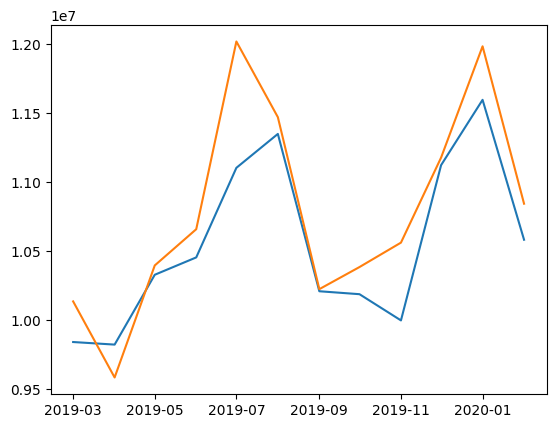

In [496]:
print(r2_score(y_valid, series_forecast_linear_regression))
plt.plot(series_forecast_linear_regression)
plt.plot(y_valid)

In [497]:
X_train

,time_dummy,demand_MWh_shifted,demand_MWh_shifted2,demand_MWh_shifted3,demand_MWh_shifted4,demand_MWh_shifted5,business_days
time_index,,,,,,,
2012-06-01,5,9.597272e+06,8.969068e+06,1.017537e+07,1.008555e+07,1.080470e+07,21
2012-07-01,6,1.029218e+07,9.597272e+06,8.969068e+06,1.017537e+07,1.008555e+07,22
2012-08-01,7,1.106653e+07,1.029218e+07,9.597272e+06,8.969068e+06,1.017537e+07,23
2012-09-01,8,1.040412e+07,1.106653e+07,1.029218e+07,9.597272e+06,8.969068e+06,20
2012-10-01,9,9.336891e+06,1.040412e+07,1.106653e+07,1.029218e+07,9.597272e+06,23
...,...,...,...,...,...,...,...
2018-10-01,81,9.808447e+06,1.174663e+07,1.262365e+07,1.194221e+07,1.068558e+07,23
2018-11-01,82,9.916300e+06,9.808447e+06,1.174663e+07,1.262365e+07,1.194221e+07,22
2018-12-01,83,1.004732e+07,9.916300e+06,9.808447e+06,1.174663e+07,1.262365e+07,21


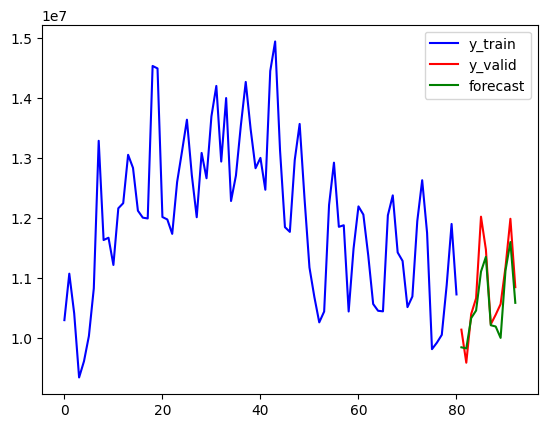

In [499]:
x_ax = np.arange(df_time_series4[['demand_MWh']].size)
plt.plot(x_ax[:(df_time_series4[['demand_MWh']].size-12)], y_train, c='blue', label='y_train')
plt.plot(x_ax[(df_time_series4[['demand_MWh']].size-12):], y_valid, c='red', label='y_valid')
plt.plot(x_ax[(df_time_series4[['demand_MWh']].size-12):], series_forecast_linear_regression, c='green', label='forecast')
plt.legend(loc="upper right")
plt.show()

# HYBRID

In [616]:
df_time_series5 = df_time_series.copy()

df_time_series5['demand_MWh_shifted'] = df_time_series5['demand_MWh'].shift(1)
# df_time_series5['demand_MWh_shifted2'] = df_time_series5['demand_MWh_shifted'].shift(1)
# df_time_series5['demand_MWh_shifted3'] = df_time_series5['demand_MWh_shifted2'].shift(1)
# df_time_series5['demand_MWh_shifted4'] = df_time_series5['demand_MWh_shifted3'].shift(1)
# df_time_series5['demand_MWh_shifted5'] = df_time_series5['demand_MWh_shifted4'].shift(1)
# df_time_series5['demand_MWh_shifted6'] = df_time_series5['demand_MWh_shifted5'].shift(1)
df_time_series5.dropna(inplace=True)
y = df_time_series5[['demand_MWh']]
X = df_time_series5.drop(columns=['demand_MWh'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=12)

In [617]:
# dp = DeterministicProcess(
#     index=df_time_series5.index,     # dates from the training data
#     constant=True,                  # dummy feature for the bias (y_intercept)
#     order=3,                        # the time dummy (trend)
#     drop=True,                      # drop terms if necessary to avoid collinearity
# )

fourier = CalendarFourier(freq="A", order=2)
dp = DeterministicProcess(
    index=df_time_series5.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend (order 1 means linear)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)
X = dp.in_sample()
X


,const,trend,trend_squared,trend_cubed,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
time_index,,,,,,,,
2012-02-01,1.0,1.0,1.0,1.0,0.507415,0.861702,0.874481,0.485060
2012-03-01,1.0,2.0,4.0,8.0,0.857315,0.514793,0.882679,-0.469977
2012-04-01,1.0,3.0,9.0,27.0,0.999963,0.008583,0.017166,-0.999853
2012-05-01,1.0,4.0,16.0,64.0,0.874481,-0.485060,-0.848351,-0.529434
2012-06-01,1.0,5.0,25.0,125.0,0.507415,-0.861702,-0.874481,0.485060
...,...,...,...,...,...,...,...,...
2019-10-01,1.0,93.0,8649.0,804357.0,-0.999917,-0.012910,0.025818,-0.999667
2019-11-01,1.0,94.0,8836.0,830584.0,-0.867456,0.497513,-0.863142,-0.504961
2019-12-01,1.0,95.0,9025.0,857375.0,-0.508671,0.860961,-0.875892,0.482508


In [618]:
# X['six_months_period'] = utils.six_months_period(X.index)
# X["Month"] = X.index.month
# X['business_days'] = [ np.busday_count(i.date(), (i + pd.DateOffset(months=1)).date()) for i in X.index]

In [619]:
# y = df_time_series[['demand_MWh']]
# X = df_time_series.drop(columns=['demand_MWh'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=12)

In [620]:
X_train.head()

,const,trend,trend_squared,trend_cubed,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
time_index,,,,,,,,
2012-02-01,1.0,1.0,1.0,1.0,0.507415,0.861702,0.874481,0.485060
2012-03-01,1.0,2.0,4.0,8.0,0.857315,0.514793,0.882679,-0.469977
2012-04-01,1.0,3.0,9.0,27.0,0.999963,0.008583,0.017166,-0.999853
2012-05-01,1.0,4.0,16.0,64.0,0.874481,-0.485060,-0.848351,-0.529434
2012-06-01,1.0,5.0,25.0,125.0,0.507415,-0.861702,-0.874481,0.485060


In [621]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
# y_pred.reshape(-1)
y_fit = pd.Series(model.predict(X_train).reshape(-1), index=X_train.index)
y_pred = pd.Series(model.predict(X_valid).reshape(-1), index=X_valid.index)

In [622]:
y_pred

time_index
2019-03-01    1.041697e+07
2019-04-01    1.001276e+07
2019-05-01    1.047045e+07
2019-06-01    1.126855e+07
2019-07-01    1.149282e+07
2019-08-01    1.084093e+07
2019-09-01    9.918823e+06
2019-10-01    9.681156e+06
2019-11-01    1.042658e+07
2019-12-01    1.150050e+07
2020-01-01    1.200170e+07
2020-02-01    1.153305e+07
Freq: MS, dtype: float64

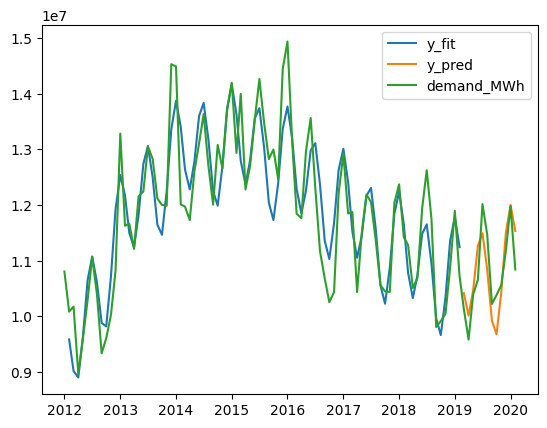

In [623]:
plt.plot(y_fit, label='y_fit')
plt.plot(y_pred, label='y_pred')
plt.plot(df_time_series['demand_MWh'], label='demand_MWh')
plt.legend()

In [624]:
X.head()

,const,trend,trend_squared,trend_cubed,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
time_index,,,,,,,,
2012-02-01,1.0,1.0,1.0,1.0,0.507415,0.861702,0.874481,0.485060
2012-03-01,1.0,2.0,4.0,8.0,0.857315,0.514793,0.882679,-0.469977
2012-04-01,1.0,3.0,9.0,27.0,0.999963,0.008583,0.017166,-0.999853
2012-05-01,1.0,4.0,16.0,64.0,0.874481,-0.485060,-0.848351,-0.529434
2012-06-01,1.0,5.0,25.0,125.0,0.507415,-0.861702,-0.874481,0.485060


In [625]:
X['six_months_period'] = utils.six_months_period(X.index)
X["month"] = X.index.month
X['business_days'] = [ np.busday_count(i.date(), (i + pd.DateOffset(months=1)).date()) for i in X.index]
# X['demand_MWh_shifted'] = df_time_series['demand_MWh'].shift(1)
# X.dropna(inplace=True)
X.head()

,const,trend,trend_squared,trend_cubed,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)",six_months_period,month,business_days
time_index,,,,,,,,,,,
2012-02-01,1.0,1.0,1.0,1.0,0.507415,0.861702,0.874481,0.485060,1.0,2,21
2012-03-01,1.0,2.0,4.0,8.0,0.857315,0.514793,0.882679,-0.469977,1.0,3,22
2012-04-01,1.0,3.0,9.0,27.0,0.999963,0.008583,0.017166,-0.999853,1.0,4,21
2012-05-01,1.0,4.0,16.0,64.0,0.874481,-0.485060,-0.848351,-0.529434,1.0,5,23
2012-06-01,1.0,5.0,25.0,125.0,0.507415,-0.861702,-0.874481,0.485060,1.0,6,21


In [626]:
y.head()

,demand_MWh
time_index,
2012-02-01,1.008555e+07
2012-03-01,1.017537e+07
2012-04-01,8.969068e+06
2012-05-01,9.597272e+06
2012-06-01,1.029218e+07


In [627]:
# y2 , X2 = y.align(X, join='outer')
# y2.head()

In [628]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=12)

In [629]:
y_fit = y_fit.squeeze()
y_pred = y_pred.squeeze()
y_train = y_train.squeeze()

In [630]:
y_resid = y_train - y_fit

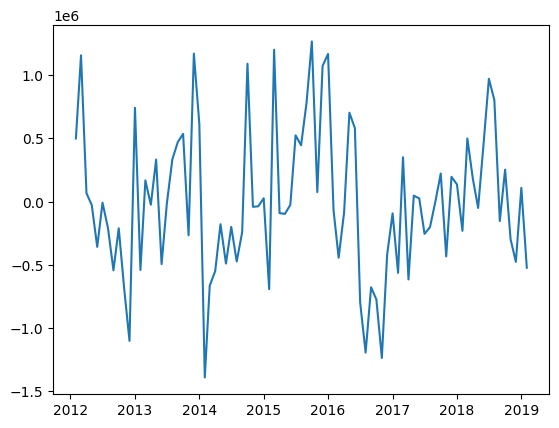

In [631]:
plt.plot(y_resid)

In [632]:

model_xgboost = XGBRegressor()
model_xgboost.fit(X_train, y_resid)

y_fit_boosted = model_xgboost.predict(X_train) + y_fit
y_pred_boosted = model_xgboost.predict(X_valid) + y_pred
# series_forecast_xgboost = pd.DataFrame(forecast_xgboost, index=y_valid.index, columns=['demand_MWh'])

In [633]:
X_train

,const,trend,trend_squared,trend_cubed,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)",six_months_period,month,business_days
time_index,,,,,,,,,,,
2012-02-01,1.0,1.0,1.0,1.0,0.507415,0.861702,0.874481,0.485060,1.0,2,21
2012-03-01,1.0,2.0,4.0,8.0,0.857315,0.514793,0.882679,-0.469977,1.0,3,22
2012-04-01,1.0,3.0,9.0,27.0,0.999963,0.008583,0.017166,-0.999853,1.0,4,21
2012-05-01,1.0,4.0,16.0,64.0,0.874481,-0.485060,-0.848351,-0.529434,1.0,5,23
2012-06-01,1.0,5.0,25.0,125.0,0.507415,-0.861702,-0.874481,0.485060,1.0,6,21
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01,1.0,81.0,6561.0,531441.0,-0.999917,-0.012910,0.025818,-0.999667,2.0,10,23
2018-11-01,1.0,82.0,6724.0,551368.0,-0.867456,0.497513,-0.863142,-0.504961,2.0,11,22
2018-12-01,1.0,83.0,6889.0,571787.0,-0.508671,0.860961,-0.875892,0.482508,2.0,12,21


r2_score: 0.7907839422268987
mean_absolute_error: 283151.8079498713
mean_absolute_percentage_error: 0.026911501753610224
mean_squared_error: 106976723454.91058
root_mean_squared_error: 327072.96350342163


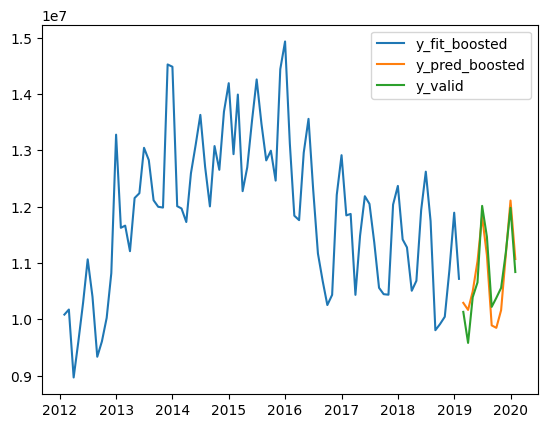

In [638]:
print(f'r2_score: {r2_score(y_valid, y_pred_boosted)}')
print(f'mean_absolute_error: {mean_absolute_error(y_valid, y_pred_boosted)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(y_valid, y_pred_boosted)}')
print(f'mean_squared_error: {mean_squared_error(y_valid, y_pred_boosted)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(y_valid, y_pred_boosted))}')
plt.plot(y_fit_boosted, label='y_fit_boosted')
plt.plot(y_pred_boosted, label='y_pred_boosted')
# plt.plot(y_train, label='y_train')
plt.plot(y_valid, label='y_valid')
plt.legend()

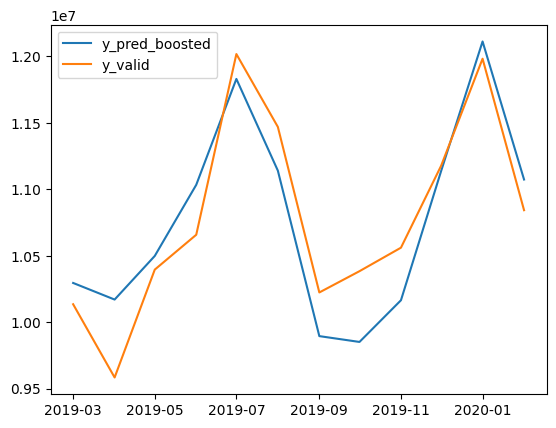

In [544]:
plt.plot(y_pred_boosted, label='y_pred_boosted')
# plt.plot(y_train, label='y_train')
plt.plot(y_valid, label='y_valid')
plt.legend()